In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

import tensorflow as tf
tf.random.set_seed(2027)  # set random seed

#import dask
#import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import get_logger, get_colormap, emtf_nbtools

try:
  import emtf_nnet
except ImportError:
  raise ImportError('Could not import emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
logger.info('Using tensorflow : {}'.format(tf.__version__))
logger.info('Using keras      : {}'.format(tf.keras.__version__))
logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : CMSSW_11_1_7
[INFO    ] Using python     : 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.4.2
[INFO    ] Using tensorflow : 2.6.0
[INFO    ] Using keras      : 2.6.0
2021-10-02 22:07:22.831232: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2021-10-02 22:07:22.831280: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login4.ufhpc): /proc/driver/nvidia/version does not exist
[INFO    ] Using emtf-nnet  : 0.0.2-dev


In [3]:
# Preamble (ML additional stuff)
import h5py
import pandas as pd
import seaborn as sns

#import tensorflow_probability as tfp
#import tensorflow_addons as tfa
#import tensorflow_model_optimization as tfmot

In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

maxevents = 10_000
#maxevents = -1

# NN pruning: True/False
do_pruning = False

# NN quantization: True/False
do_quantization = False

# Input files
features_fname = 'features.210922.h5'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 0
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : 10000


### Load data

In [5]:
def load_features(fname):
  logger.info('Loading from {}'.format(fname))
  with h5py.File(fname, 'r') as loaded:
    features = np.array(loaded['features'])
    truths = np.array(loaded['truths'])
  logger.info('features: {} truths: {}'.format(
      (features.shape, features.dtype.name),
      (truths.shape, truths.dtype.name)))
  return (features, truths)

In [6]:
# Load features and truths
features, truths = load_features(features_fname)

[INFO    ] Loading from features.210922.h5
[INFO    ] features: ((1690392, 40), 'int32') truths: ((1690392, 10), 'float32')


In [7]:
from emtf_nnet.architecture import endless_nnet_v3

# Split into train/test
x_train, x_test, y_train, y_test = endless_nnet_v3.get_x_y_data(
    features, truths, batch_size=8192)
logger.info('x_train: {} y_train: {} x_test: {} y_test: {}'.format(
    x_train.shape, y_train.shape, x_test.shape, y_test.shape))

[INFO    ] x_train: (1269760, 40) y_train: (1269760, 1) x_test: (420632, 40) y_test: (420632, 1)


### Create model

In [8]:
# Set hyperparameters
learning_rate = 0.005
final_learning_rate = learning_rate * 0.02
gradient_clipnorm = 10.
warmup_epochs = 30
epochs = warmup_epochs + 120
batch_size = 2048

num_train_samples = x_train.shape[0]
callbacks = [emtf_nnet.keras.callbacks.LearningRateLogger(),]
logger.info('learning_rate: {} final_learning_rate: {} epochs: {} batch_size: {}'.format(
    learning_rate, final_learning_rate, epochs, batch_size))

# Create model
preprocessing_layer = endless_nnet_v3.create_preprocessing_layer(x_train)
lr_schedule = endless_nnet_v3.create_lr_schedule(
    num_train_samples, epochs=epochs, warmup_epochs=warmup_epochs, batch_size=batch_size,
    learning_rate=learning_rate, final_learning_rate=final_learning_rate)
optimizer = endless_nnet_v3.create_optimizer(
    lr_schedule, gradient_clipnorm=gradient_clipnorm)
model = endless_nnet_v3.create_model(
    preprocessing_layer=preprocessing_layer, optimizer=optimizer)
model.summary()

[INFO    ] learning_rate: 0.005 final_learning_rate: 0.0001 epochs: 150 batch_size: 2048


Model: "nnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (FeatureNormal (None, 40)                80        
_________________________________________________________________
dense (MutatedDense)         (None, 24)                960       
_________________________________________________________________
batch_normalization (Mutated (None, 24)                96        
_________________________________________________________________
activation (TanhActivation)  (None, 24)                0         
_________________________________________________________________
dense_1 (MutatedDense)       (None, 24)                576       
_________________________________________________________________
batch_normalization_1 (Mutat (None, 24)                96        
_________________________________________________________________
activation_1 (TanhActivation (None, 24)                0

2021-10-02 22:07:32.017275: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train model

In [9]:
# Training utils
class HistoryPlotter(object):
  def __init__(self, history, metric=None):
    self.history = history
    if metric is None:
      metric = 'loss'
    self.metric = metric

  def plot(self):
    train_value = self.history.history[self.metric]
    val_value = self.history.history['val_' + self.metric]
    lr_value = self.history.history['lr']
    maxnorm_value = self.history.history['gradient_maxnorm']
    tup = (len(self.history.epoch), len(self.history.epoch), self.metric,
           train_value[-1], 'val_' + self.metric, val_value[-1])
    logger.info('Epoch {}/{} - {}: {:.4f} - {}: {:.4f}'.format(*tup))

    fig, axs = plt.subplots(1, 2, figsize=(6, 6/2), tight_layout=True)
    ax = axs[0]
    ax.plot(self.history.epoch, lr_value, color='C0')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Learning rate')
    ax.grid(True)
    ax = axs[1]
    ax.plot(self.history.epoch, train_value, color='C0', label='Train')
    ax.plot(self.history.epoch, val_value, '--', color='C0', label='Val')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(self.metric.replace('_', ' ').title())
    ax.set_ylim(0, 1.5)
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(6, 6/2), tight_layout=True)
    ax = axs[0]
    ax.plot(self.history.epoch, maxnorm_value, color='C0')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Gradient maxnorm')
    ax.set_ylim(0, 1.5)
    ax.grid(True)
    plt.show()


class ModelTrainer(object):
  def __init__(self, model, log_dir='keras_logs', prefix='', suffix='.log'):
    self.model = model
    self.log_dir = log_dir
    self.prefix = prefix
    self.suffix = suffix

  def fit(self, *args, **kwargs):
    from contextlib import redirect_stdout
    from datetime import datetime
    import os
    import tempfile
    if not os.path.exists(self.log_dir):
      os.makedirs(self.log_dir)
    fd, name = tempfile.mkstemp(prefix=self.prefix, suffix=self.suffix, dir=self.log_dir, text=True)

    start_time = datetime.now()
    logger.info('Begin training ...')

    # Fit
    with os.fdopen(fd, 'w') as f:
      with redirect_stdout(f):
        history = self.model.fit(*args, **kwargs)
    logger.info('Done training. Time elapsed: {}'.format(str(datetime.now() - start_time)))

    # Plot history
    HistoryPlotter(history).plot()
    return history

[INFO    ] Begin training ...
2021-10-02 22:07:32.453236: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-02 22:07:33.778765: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x2b39340a3320 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-02 22:07:33.778795: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-10-02 22:07:33.785778: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-10-02 22:07:33.827344: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
[INFO    ] Done training. Time elapsed: 0:06:11.162191
[INFO    ] Epoch 150/150 - loss: 0.0682 - val_loss: 0.0679


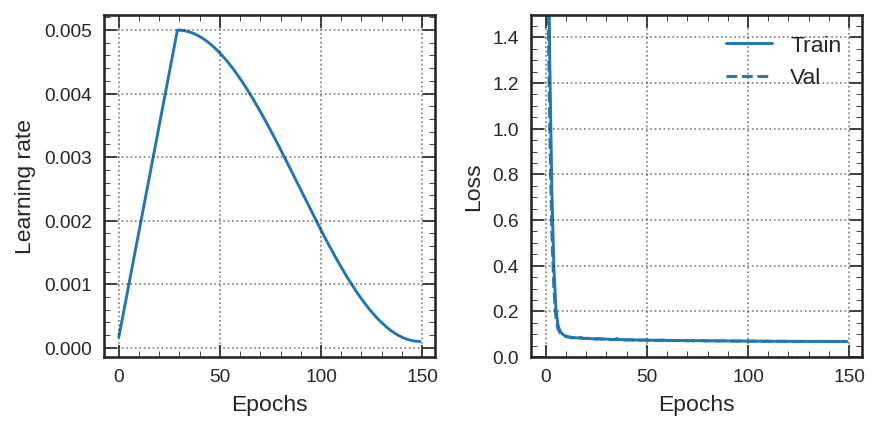

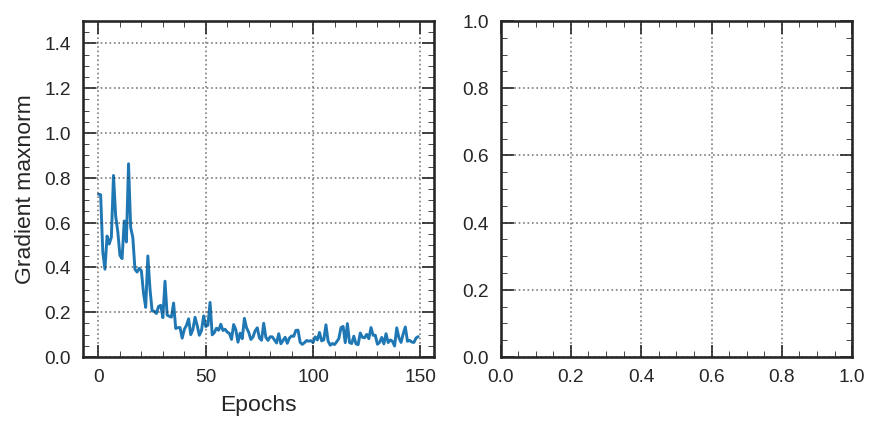

/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
[INFO    ] Saved as nnet_model.h5


In [10]:
# Train model
history = ModelTrainer(model).fit(
    x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,
    validation_data=(x_test, y_test), shuffle=True)
emtf_nnet.keras.utils.save_nnet_model(model)
logger.info('Saved as {}'.format(model.name + '.h5'))

### Pruning

In [11]:
# Create pruned model
if do_pruning:
  pass

### Quantization

In [12]:
# Create quantized model
if do_quantization:
  lr_schedule = endless_nnet_v3.create_lr_schedule(
      num_train_samples, epochs=epochs, warmup_epochs=0, batch_size=batch_size,
      learning_rate=learning_rate, final_learning_rate=final_learning_rate)
  optimizer = endless_nnet_v3.create_optimizer(
      lr_schedule, gradient_clipnorm=gradient_clipnorm)
  quant_model = endless_nnet_v3.create_quant_model(
      model, optimizer=optimizer)
  quant_model.summary()

In [13]:
# Train quantized model
if do_quantization:
  history = ModelTrainer(quant_model).fit(
      x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,
      validation_data=(x_test, y_test), shuffle=True)

  base_model = model
  model = quant_model
  emtf_nnet.keras.utils.save_nnet_model(model)
  logger.info('Saved as {}'.format(model.name + '.h5'))

### Evaluate model

In [14]:
# Make predictions
y_test_true = y_test.copy()
y_test_pred = model.predict(x_test, batch_size=8192)

# Subsets of x_test, y_test_true, y_test_pred
index_array = np.arange(x_test.shape[0])
shuffle = True
if shuffle:
  np.random.shuffle(index_array)

x_test_1 = x_test[index_array[:maxevents]]
y_test_true_1 = y_test_true[index_array[:maxevents]]
y_test_pred_1 = y_test_pred[index_array[:maxevents]]

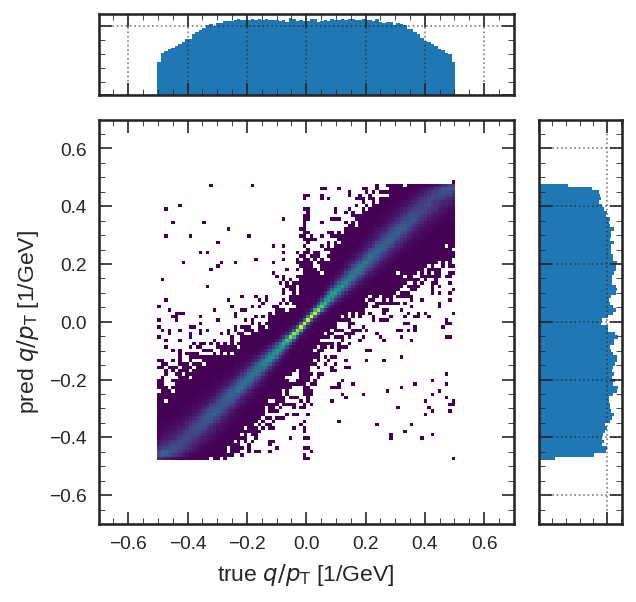

In [15]:
# Plot predictions
fig = plt.figure(figsize=(4.5, 4.5))

xx = np.squeeze(y_test_true)
yy = np.squeeze(y_test_pred)

gs = plt.GridSpec(2, 2, width_ratios=(5,1), height_ratios=(1,5), hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[1,0])
ax_top = fig.add_subplot(gs[0,0], sharex=ax)
ax_right = fig.add_subplot(gs[1,1], sharey=ax)

ax.hist2d(xx, yy, bins=(120,120), range=((-0.7,0.7),(-0.7,0.7)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
ax_top.hist(xx, bins=120, range=(-0.7,0.7))
ax_top.tick_params(labelbottom=False, labelleft=False)
ax_right.hist(yy, bins=120, range=(-0.7,0.7), orientation='horizontal')
ax_right.tick_params(labelbottom=False, labelleft=False)

plt.show()

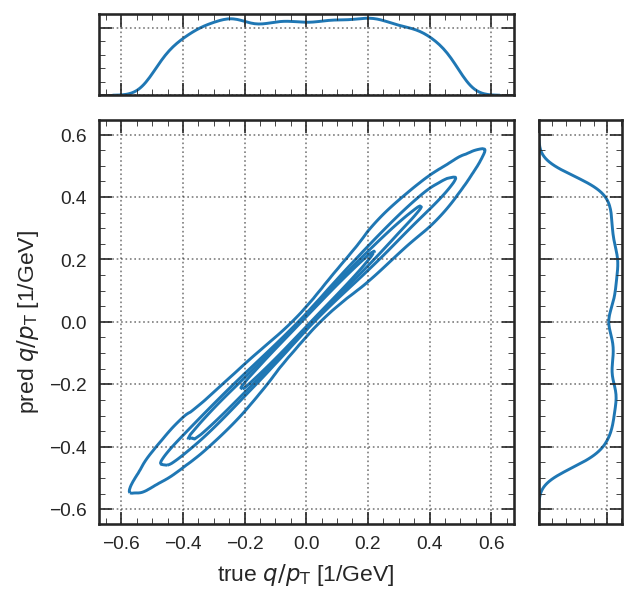

In [16]:
# Plot predictions
fig = plt.figure(figsize=(4.5, 4.5))

xx = np.squeeze(y_test_true_1)
yy = np.squeeze(y_test_pred_1)

gs = plt.GridSpec(2, 2, width_ratios=(5,1), height_ratios=(1,5), hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[1,0])
ax_top = fig.add_subplot(gs[0,0], sharex=ax)
ax_right = fig.add_subplot(gs[1,1], sharey=ax)

df = pd.DataFrame({'x': xx, 'y': yy})
sns.kdeplot(data=df, x='x', y='y', levels=5, bw_adjust=1, ax=ax)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
sns.kdeplot(data=df, x='x', bw_adjust=1, ax=ax_top)
ax_top.set_xlabel('')
ax_top.set_ylabel('')
ax_top.tick_params(labelbottom=False, labelleft=False)
sns.kdeplot(data=df, y='y', bw_adjust=1, ax=ax_right)
ax_right.set_xlabel('')
ax_right.set_ylabel('')
ax_right.tick_params(labelbottom=False, labelleft=False)

plt.show()

[INFO    ] mu, sig, mse, mae, mad: 2.3130e-04, 0.0355, 0.0014, 0.0249, 0.0256
[INFO    ] gaus fit (a, mu, sig): 32268.15, 9.5567e-05, 0.0236
[INFO    ] mu, sig, mse, mae, mad: -1.3342e-04, 0.0157, 0.0006, 0.0120, 0.0111
[INFO    ] gaus fit (a, mu, sig): 3986.36, -1.1778e-04, 0.0102


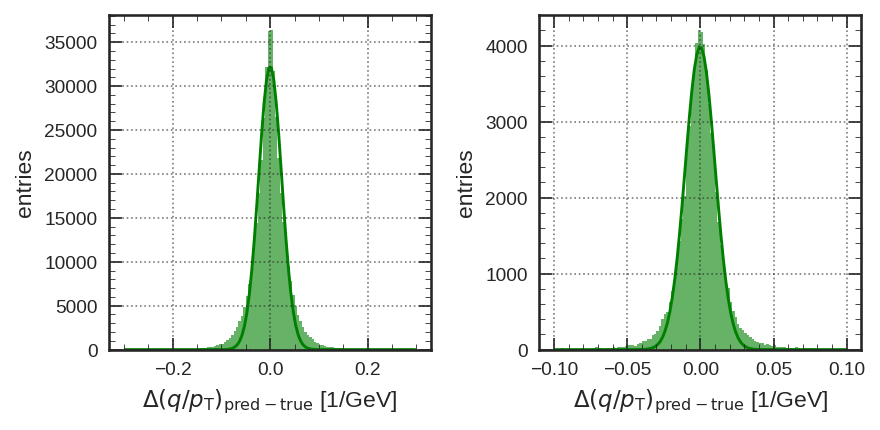

In [17]:
# Plot Delta(q/pt)
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)

ya = np.squeeze(y_test_true)
yb = np.squeeze(y_test_pred)
yy = yb - ya
yy_core = yy[np.abs(yy) < 0.3]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

# Repeat with pt > 14 GeV
sel = np.squeeze(np.reciprocal(np.abs(y_test_true)) > 14.)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy) < 0.1]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.1,0.1), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

plt.show()

[INFO    ] mu, sig, mse, mae, mad: -2.0696e-03, 0.2142, 126.1363, 0.2677, 0.1414
[INFO    ] gaus fit (a, mu, sig): 39367.55, -1.1151e-02, 0.1287
[INFO    ] mu, sig, mse, mae, mad: -8.2052e-02, 0.3728, 773.9721, 0.9719, 0.3273
[INFO    ] gaus fit (a, mu, sig): 3167.79, -1.1726e-01, 0.2384


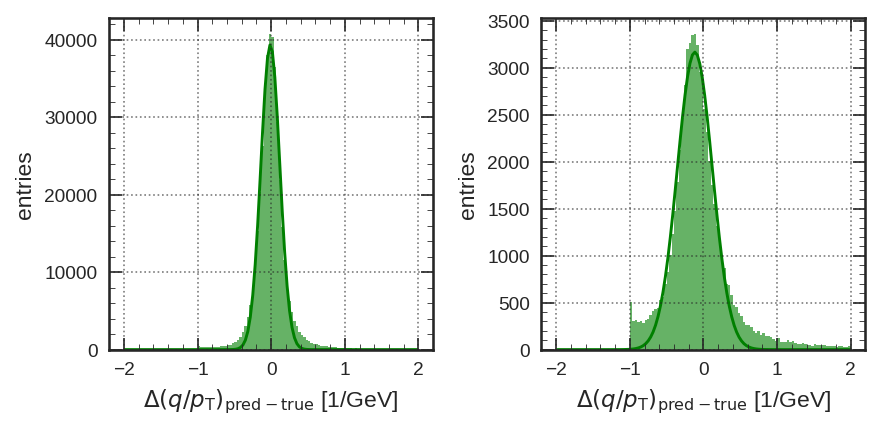

In [18]:
# Plot Delta(q/pt) / pt
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)

ya = np.squeeze(np.abs(y_test_true / y_test_true))
yb = np.squeeze(np.abs(y_test_true / y_test_pred))
yy = yb - ya
yy_core = yy[np.abs(yy) < 1.5]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=120, range=(-2,2), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

# Repeat with pt > 14 GeV
sel = np.squeeze(np.reciprocal(np.abs(y_test_true)) > 14.)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy) < 1.5]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=120, range=(-2,2), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

plt.show()

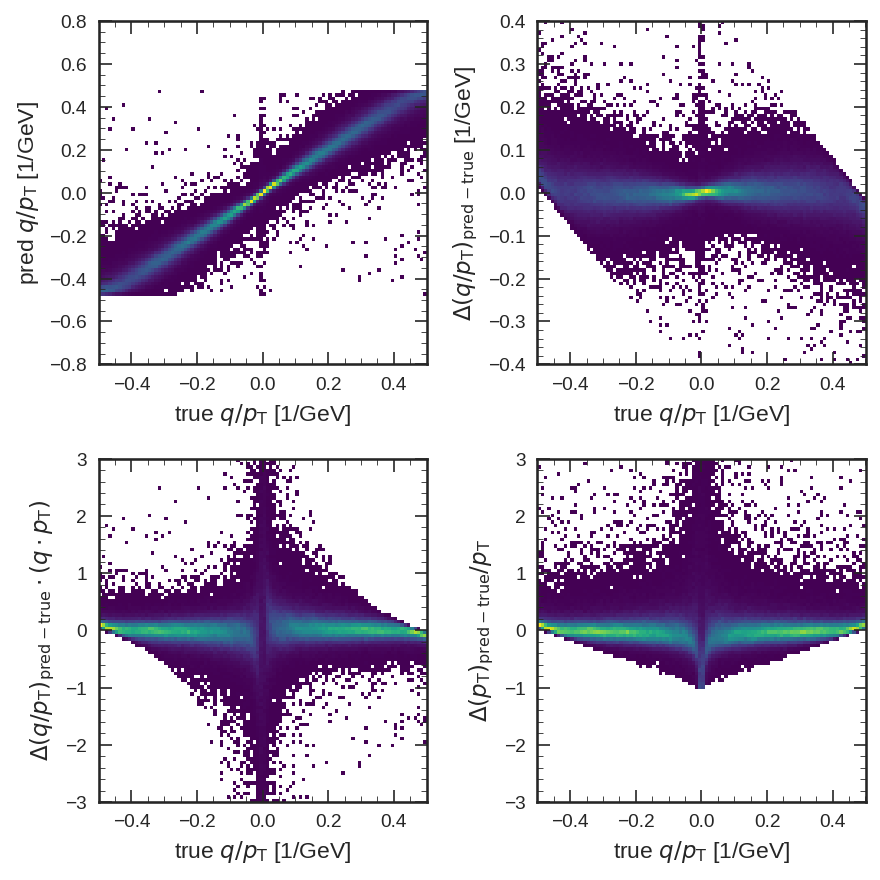

In [19]:
# Plot correlations
fig, axs = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True)

xx = np.squeeze(y_test_true)
yy = np.squeeze(y_test_pred)
ax = axs[0,0]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')

yy = np.squeeze(y_test_pred - y_test_true)
ax = axs[0,1]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')

with np.errstate(divide='ignore'):
  yy = np.squeeze((y_test_pred - y_test_true) / np.abs(y_test_true))
ax = axs[1,0]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}} \cdot (q \cdot p_{\mathrm{T}})$')

with np.errstate(divide='ignore'):
  yy = np.squeeze(np.abs(y_test_true / y_test_pred) - 1)
ax = axs[1,1]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')

plt.show()

In [20]:
# Make better resolution plot
# resolution defined as Delta(pt) over pt (no charge), binned in 1/pt (also no charge)
xx = np.squeeze(np.abs(y_test_true))
yy = np.squeeze(np.abs(y_test_true/y_test_pred) - 1)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xx_pt = np.zeros(nbinsx, dtype=np.float32)
yy_mu = np.zeros(nbinsx, dtype=np.float32)
yy_sig = np.zeros(nbinsx, dtype=np.float32)
yy_tail = np.zeros(nbinsx, dtype=np.float32)
yy_cov = np.zeros(nbinsx, dtype=np.float32)

cache = {}

for i in range(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue

  pt = xx_i.mean()
  pt = 1.0 / pt

  yy_i = yy[inds==i]
  yy_i = yy_i[(-1.0 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = yy_i.mean(), yy_i.std()
  assert np.abs(mu) < 1.0
  assert np.abs(sig) < 2.0

  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1]) / 2
  try:
    popt = emtf_nbtools.fit_gaus(hist, edges, mu=mu, sig=sig)
  except:
    popt = np.array([np.nan, np.nan, np.nan])
  #print(i, len(xx_i), mu, sig, pt, popt)

  ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
  tail = hist - ydata        # check non-gaussian high tail
  tail[tail < 0] = 0         # ignore hist < gaus
  tail[xdata < popt[2]] = 0  # ignore low tail
  tail = tail.sum() / len(xx_i)

  pct = np.percentile(yy_i, (100 - 90), overwrite_input=True)  # find 10-percentile
  cov = -1 * pct / popt[2]
  # If truly gaussian, the required number of sigmas is 1.28155 for 90% coverage
  #print(scipy.special.erfinv(0.80) * np.sqrt(2))

  xx_pt[i] = pt
  yy_mu[i] = popt[1]
  yy_sig[i] = popt[2]
  yy_tail[i] = tail
  yy_cov[i] = cov

  if 14. < pt < 15.:
    cache[0] = (i, xx_i, yy_i)
  elif 20. < pt < 22.:
    cache[1] = (i, xx_i, yy_i)
  elif 25. < pt < 28.:
    cache[2] = (i, xx_i, yy_i)
  elif 28. < pt < 33.:
    cache[3] = (i, xx_i, yy_i)

[INFO    ] gaus fit (a, mu, sig): 227.04, -6.8596e-02, 0.1883
[INFO    ] gaus fit (a, mu, sig): 225.49, -8.8075e-02, 0.1879
[INFO    ] gaus fit (a, mu, sig): 208.07, -1.1401e-01, 0.2016
[INFO    ] gaus fit (a, mu, sig): 198.48, -1.2762e-01, 0.2069


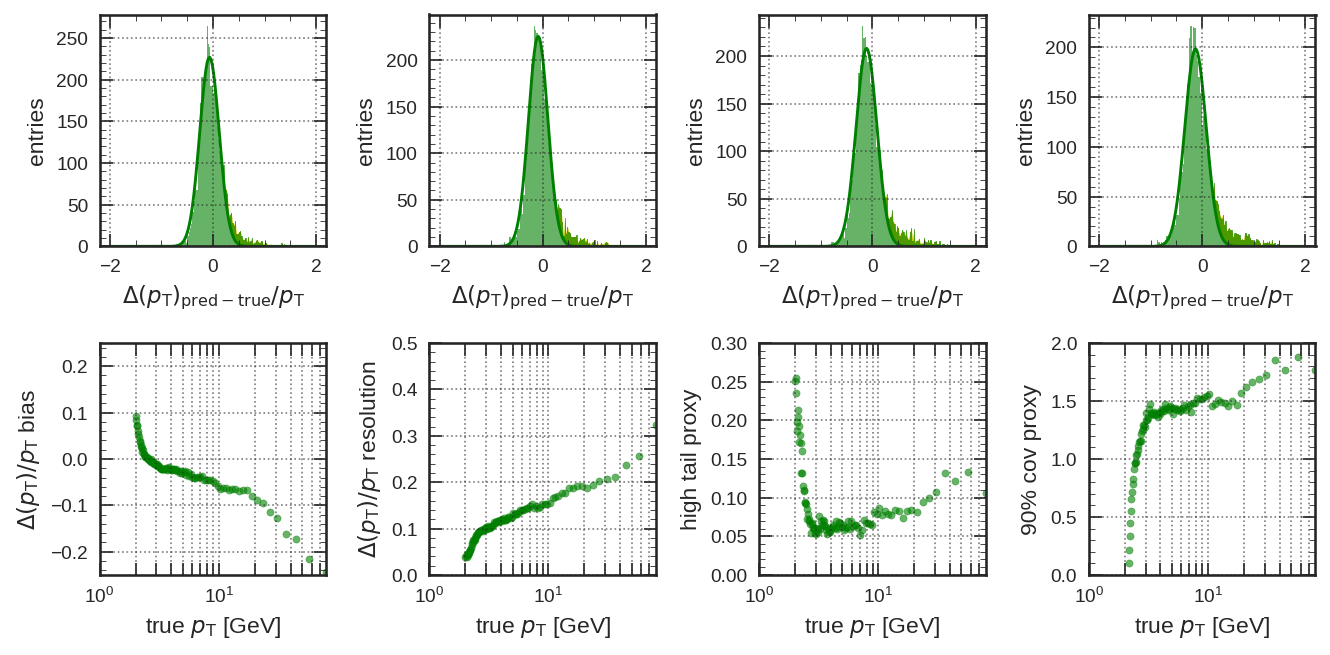

In [21]:
# Make better resolution plot
fig, axs = plt.subplots(2, 4, figsize=(4.5*2,4.5), tight_layout=True)

for i in range(4):
  ax = axs[0,i]
  (ii, xx_i, yy_i) = cache[i]  # read from cache
  hist, edges, _ = ax.hist(yy_i, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  popt = emtf_nbtools.fit_gaus(hist, edges, mu=yy_mu[ii], sig=yy_mu[ii])
  xdata = (edges[1:] + edges[:-1])/2
  ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
  tail = hist - ydata        # check non-gaussian high tail
  tail[tail < 0] = 0         # ignore hist < gaus
  tail[xdata < popt[2]] = 0  # ignore low tail
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata + tail, facecolor='y')
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')
  logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

ax = axs[1,0]
ax.scatter(xx_pt, yy_mu, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-0.25,0.25)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ bias')

ax = axs[1,1]
ax.scatter(xx_pt, yy_sig, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')

ax = axs[1,2]
ax.scatter(xx_pt, yy_tail, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'high tail proxy')

ax = axs[1,3]
ax.scatter(xx_pt, yy_cov, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'90% cov proxy')

plt.show()

### Calibrate pt

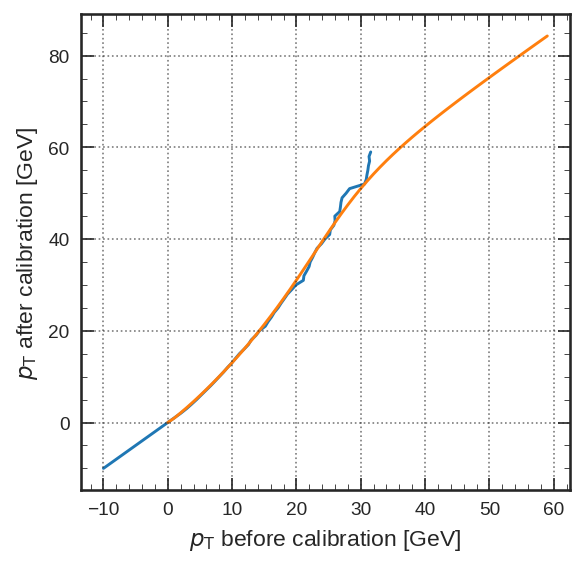

[INFO    ] [ 0.000,  1.000,  2.000,  2.902,  3.707,  4.480,  5.196,  5.923,  6.655,
  7.335,  8.003,  8.676,  9.286,  9.961, 10.543, 11.140, 11.868, 12.547,
 12.968, 13.712, 14.248, 15.171, 15.601, 16.128, 16.553, 17.148, 17.608,
 18.115, 18.610, 19.284, 19.918, 21.074, 21.167, 21.579, 21.965, 22.136,
 22.518, 22.843, 23.209, 23.906, 24.424, 25.170, 25.273, 25.815, 26.009,
 25.967, 26.731, 26.841, 26.925, 27.094, 27.724, 28.264, 30.573, 30.856,
 30.963, 31.104, 31.199, 31.376, 31.287, 31.550]
[INFO    ] [ 0.000,  0.961,  2.109,  3.312,  4.567,  5.869,  7.218,  8.611, 10.047,
 11.527, 13.050, 14.618, 16.232, 17.895, 19.609, 21.378, 23.203, 25.085,
 27.024, 29.017, 31.059, 33.141, 35.249, 37.369, 39.481, 41.566, 43.605,
 45.580, 47.480, 49.294, 51.020, 52.658, 54.214, 55.693, 57.104, 58.455,
 59.753, 61.007, 62.222, 63.404, 64.559, 65.690, 66.801, 67.895, 68.975,
 70.041, 71.097, 72.143, 73.182, 74.213, 75.238, 76.258, 77.273, 78.284,
 79.292, 80.296, 81.297, 82.296, 83.292, 84.287]
[INF

In [22]:
# Calibrate pt
from scipy.interpolate import Rbf

pt_true = np.squeeze(np.reciprocal(np.abs(y_test_true)))
pt_pred = np.squeeze(np.reciprocal(np.abs(y_test_pred)))
pt_pred = np.clip(pt_pred, 0., 7000.)

coverage = 90.  # nominal coverage
coverage += 1.5  # additional coverage due to fiducial cuts
xmin, xmax, nbinsx = 0., 60., 60
edges = np.linspace(xmin, xmax, num=(nbinsx + 1))

# Map pt -> pt bin
calib_indices = emtf_nbtools.hist_digitize_inclusive(pt_true, edges)
# Map pt bin -> 90% coverage threshold
calib_data = np.arange(nbinsx).astype(np.float32)

for i in range(nbinsx):
  # Skip 2 GeV and below
  if edges[i] <= 2:
    continue

  # Customize step size
  if edges[i] <= 20:
    step = 2
  elif edges[i] <= 30:
    step = 4
  elif edges[i] <= 40:
    step = 6
  else:
    step = 8

  sel = (i <= calib_indices) & (calib_indices <= (i + step - 1))
  selected = pt_pred[sel]
  thres = np.percentile(selected, 100. - coverage, overwrite_input=True)
  calib_data[i] = thres


# Plot
fig, ax = plt.subplots()

edges_neg_x = np.linspace(-10, -1, num=10)  # extend edges into negative x
xdata = np.concatenate((edges_neg_x, calib_data))
ydata = np.concatenate((edges_neg_x, edges[:-1]))
# These parameters require some tuning
rbfi = Rbf(xdata[:-8], ydata[:-8], epsilon=10., smooth=1., function='multiquadric')
ax.plot(xdata, ydata)

xdata = edges[:-1]
ydata = rbfi(xdata)
ydata[0] = 0.  # force to start with 0
ax.plot(xdata, ydata)
ax.set_xlabel(r'$p_{\mathrm{T}}$ before calibration [GeV]')
ax.set_ylabel(r'$p_{\mathrm{T}}$ after calibration [GeV]')
plt.show()

logger.info(np.array2string(calib_data, separator=', ', precision=3, floatmode='fixed'))
logger.info(np.array2string(ydata, separator=', ', precision=3, floatmode='fixed'))
with np.errstate(divide='ignore', invalid='ignore'):
  logger.info(np.array2string(ydata / xdata, separator=', ', precision=3, floatmode='fixed'))

In [23]:
def find_emtf_pt_initializer():
  lut = ydata.copy()
  lut = np.asarray(lut, dtype=np.float32)
  last_binx = 50  # do not use the entries beyond this bin
  last_binx = np.asarray(last_binx, dtype=np.int32)
  xmin, xmax, nbinsx = 0., 60., 60
  step = (xmax - xmin) / nbinsx  # bin size
  assert nbinsx == len(lut)

  def lookup(x):
    x = np.asarray(x, dtype=np.float32)
    binx = np.floor((x - xmin) / step).astype(np.int32)
    binx_mask = binx < last_binx
    binx_safe = np.where(binx_mask, binx, last_binx)
    x0, x1 = binx_safe * step, (binx_safe + 1) * step
    y0, y1 = lut[binx_safe], lut[binx_safe + 1]
    y = (x - x0) / (x1 - x0) * (y1 - y0) + y0  # interpolate
    y_lin = x / x0 * y0  # extrapolate
    return np.where(binx_mask, y, y_lin)
  return lookup


# The initializer will instantiate the lookup table
find_emtf_pt = find_emtf_pt_initializer()

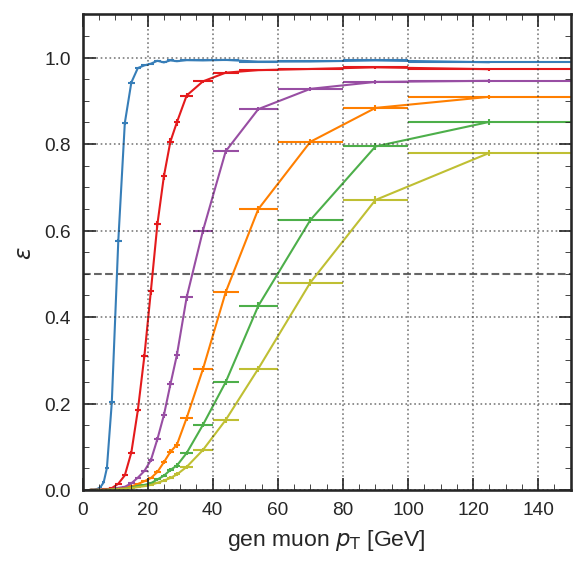

[INFO    ] eff @10/20/30/40/50/60 GeV: 57.67%, 45.97%, 44.57%, 45.77%, 42.58%, 47.98%


In [24]:
# Efficiency vs pt
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20.,
               22., 24., 26., 28., 30., 34., 40., 48., 60., 80., 100., 150.)
pt_list = (10., 20., 30., 40., 50., 60.)
pt_palette = ('#377eb8', '#e41a1c', '#984ea3', '#ff7f00', '#4daf4a', '#bfbf33', '#a65628', '#f781bf')

denom_hists = []
num_hists = []
eff_hists = []

# Create histograms
for pt in pt_list:
  pt_passed = (pt_pred > pt)
  denom_hist, edges = np.histogram(pt_true, bins=eff_pt_bins)
  num_hist, edges = np.histogram(pt_true[pt_passed], bins=eff_pt_bins)
  with np.errstate(divide='ignore', invalid='ignore'):
    eff_hist = np.true_divide(num_hist, denom_hist)
  denom_hists.append(denom_hist)
  num_hists.append(num_hist)
  eff_hists.append(eff_hist)


# Plot
fig, ax = plt.subplots()

for denom_hist, num_hist, eff_hist, color in zip(denom_hists, num_hists, eff_hists, pt_palette):
  xdata = (edges[1:] + edges[:-1]) / 2
  xerr = (edges[1:] - edges[:-1]) / 2
  yerr = emtf_nbtools.find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

ax.axhline(0.5, ls='dashed', lw=1, color='k', alpha=0.6)
ax.set_xlim(0, edges[-1])
ax.set_ylim(0, 1.1)
ax.set_xlabel(r'gen muon $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\varepsilon$')
plt.show()

logger.info("eff @10/20/30/40/50/60 GeV: {:.2%}, {:.2%}, {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(
    eff_hists[0][11], eff_hists[1][16], eff_hists[2][21], eff_hists[3][23], eff_hists[4][24],
    eff_hists[5][25]))

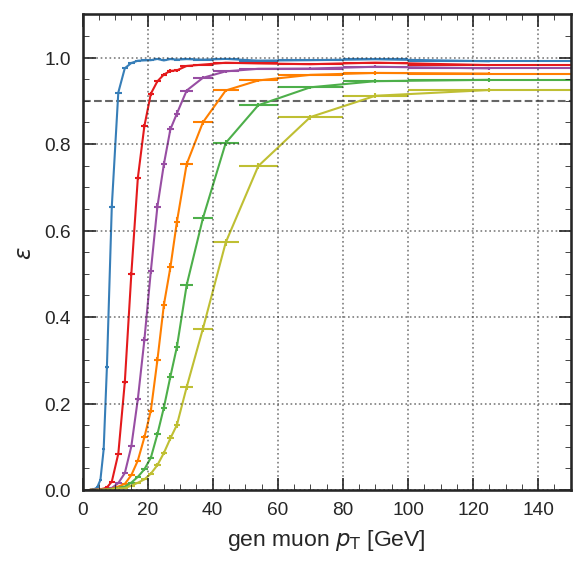

[INFO    ] eff @10/20/30/40/50/60 GeV: 91.93%, 91.65%, 92.38%, 92.39%, 88.99%, 86.25%


In [25]:
# Efficiency vs pt (after calibration)
pt_pred_calib = find_emtf_pt(pt_pred)

denom_hists = []
num_hists = []
eff_hists = []

# Create histograms
for pt in pt_list:
  pt_passed = (pt_pred_calib > pt)
  denom_hist, edges = np.histogram(pt_true, bins=eff_pt_bins)
  num_hist, edges = np.histogram(pt_true[pt_passed], bins=eff_pt_bins)
  with np.errstate(divide='ignore', invalid='ignore'):
    eff_hist = np.true_divide(num_hist, denom_hist)
  denom_hists.append(denom_hist)
  num_hists.append(num_hist)
  eff_hists.append(eff_hist)


# Plot
fig, ax = plt.subplots()

for denom_hist, num_hist, eff_hist, color in zip(denom_hists, num_hists, eff_hists, pt_palette):
  xdata = (edges[1:] + edges[:-1]) / 2
  xerr = (edges[1:] - edges[:-1]) / 2
  yerr = emtf_nbtools.find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

ax.axhline(0.9, ls='dashed', lw=1, color='k', alpha=0.6)
ax.set_xlim(0, edges[-1])
ax.set_ylim(0, 1.1)
ax.set_xlabel(r'gen muon $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\varepsilon$')
plt.show()

logger.info("eff @10/20/30/40/50/60 GeV: {:.2%}, {:.2%}, {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(
    eff_hists[0][11], eff_hists[1][16], eff_hists[2][21], eff_hists[3][23], eff_hists[4][24],
    eff_hists[5][25]))

### Inspect weights

In [26]:
# Make ridgeplot
def min_max(x):
  return (np.min(x), np.max(x))

def ridgeplot():
  n = xx.shape[1]
  fig, axs = plt.subplots(n, 1, figsize=(6,n*0.25), sharex=True, sharey=False,
                          gridspec_kw=dict(hspace=-0.5))
  pal = sns.cubehelix_palette(n, rot=-.4, light=.7)

  for i in range(n):
    if n == 1:
      ax = axs
    else:
      ax = axs[(n - 1) - i]
    limit = 4
    sns.kdeplot(np.clip(xx[:, i], -limit, limit), bw_adjust=0.25, clip_on=False,
                fill=True, alpha=1, color=pal[i], ax=ax)
    sns.kdeplot(np.clip(xx[:, i], -limit, limit), bw_adjust=0.25, clip_on=False,
                lw=1.0, color='w', ax=ax)

    # Remove borders, axis ticks, labels, and make background transparent
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    if i == 0:
      ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
    spines = ['top', 'right', 'left', 'bottom']
    for s in spines:
      if s != 'bottom':
        ax.spines[s].set_visible(False)
    ax.patch.set_alpha(0)

    # Label
    ax.text(0, 0.2, str(i), fontsize=8, ha='right', va='center', transform=ax.transAxes)

  logger.info('(min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  plt.show()

In [27]:
# Inspect intermediate layers
if not do_quantization:
  extractor_layers = [model.get_layer('preprocessing').output,
                      model.get_layer('dense').output,
                      model.get_layer('batch_normalization').output,
                      model.get_layer('activation').output,
                      model.get_layer('dense_1').output,
                      model.get_layer('batch_normalization_1').output,
                      model.get_layer('activation_1').output,
                      model.get_layer('dense_2').output,
                      model.get_layer('batch_normalization_2').output,
                      model.get_layer('activation_2').output,
                      model.get_layer('dense_final').output,]

  extractor = tf.keras.Model(inputs=model.inputs, outputs=extractor_layers)

  extracted = extractor(x_test_1)
  extracted = iter(extracted)
  extracted_preprocessing = next(extracted).numpy()
  extracted_dense = next(extracted).numpy()
  extracted_batch_normalization = next(extracted).numpy()
  extracted_activation = next(extracted).numpy()
  extracted_dense_1 = next(extracted).numpy()
  extracted_batch_normalization_1 = next(extracted).numpy()
  extracted_activation_1 = next(extracted).numpy()
  extracted_dense_2 = next(extracted).numpy()
  extracted_batch_normalization_2 = next(extracted).numpy()
  extracted_activation_2 = next(extracted).numpy()
  extracted_dense_final = next(extracted).numpy()

/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
[INFO    ] (min, max): -6.5781, 6.9111


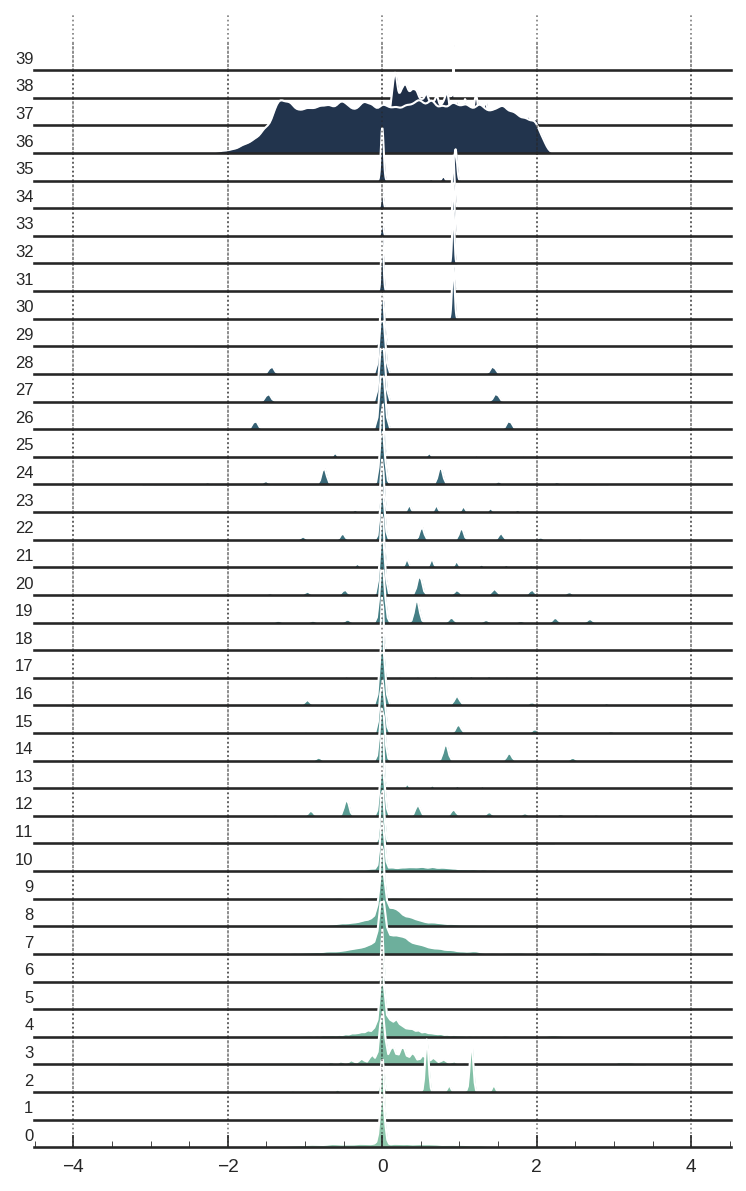

[INFO    ] (min, max): -7.9772, 11.1340


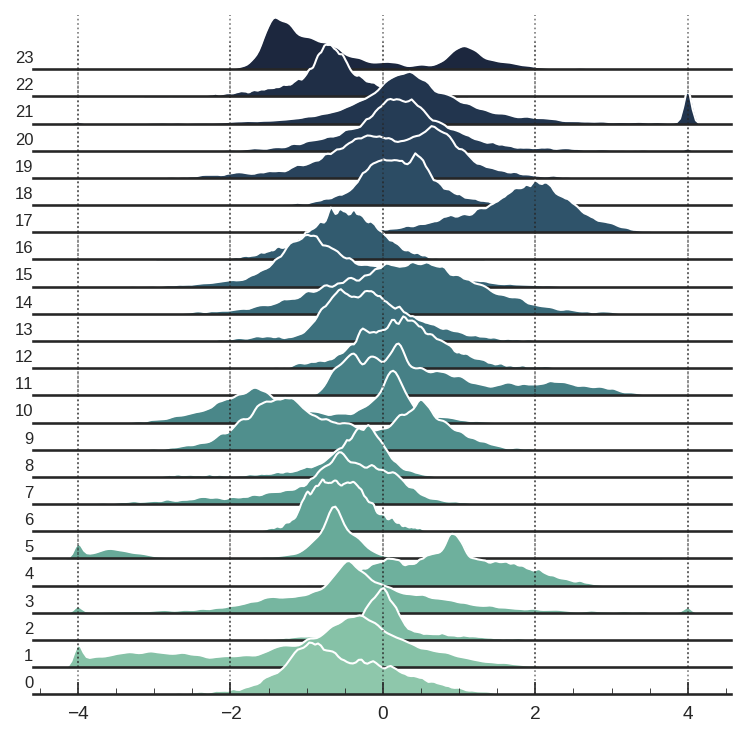

[INFO    ] (min, max): -1.0000, 1.0000


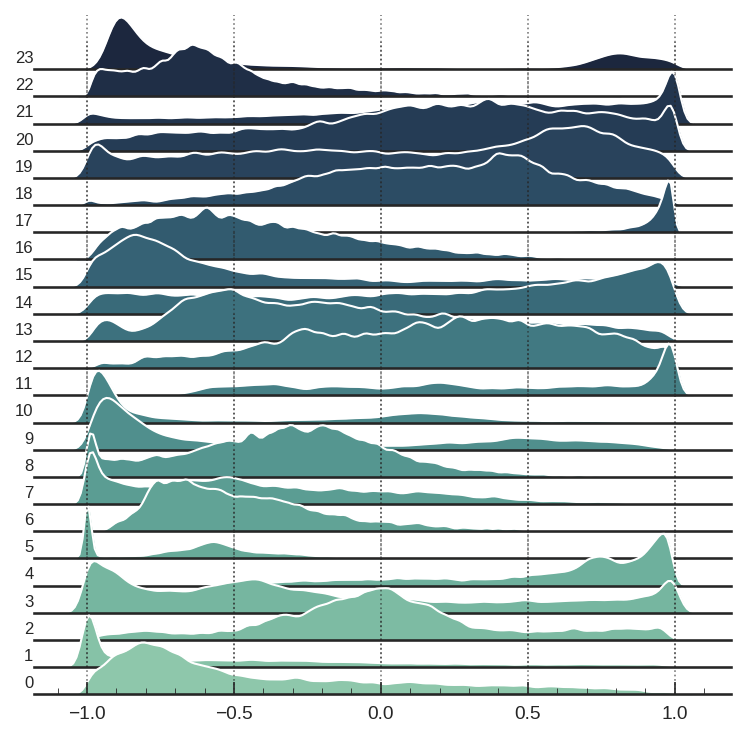

[INFO    ] (min, max): -12.0194, 9.4436


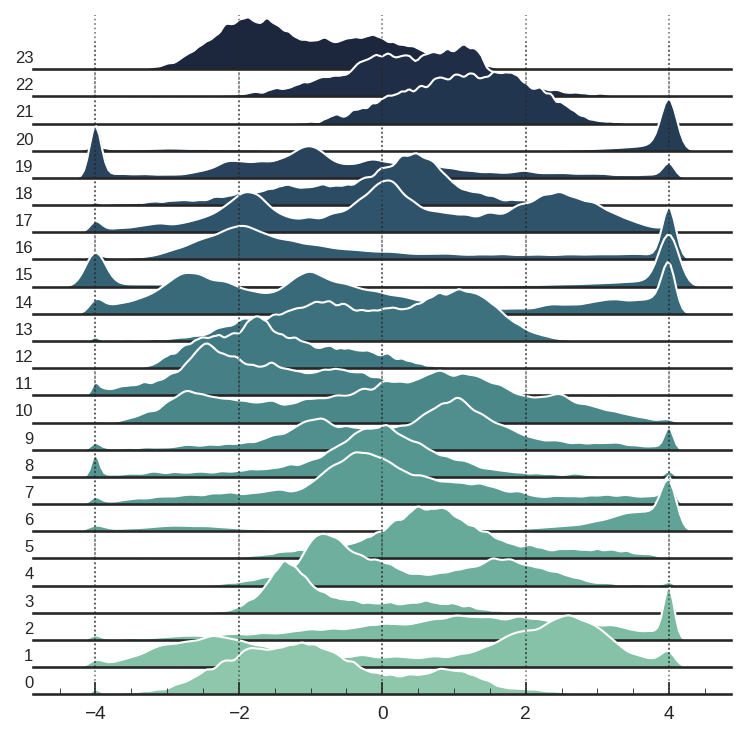

[INFO    ] (min, max): -1.0000, 1.0000


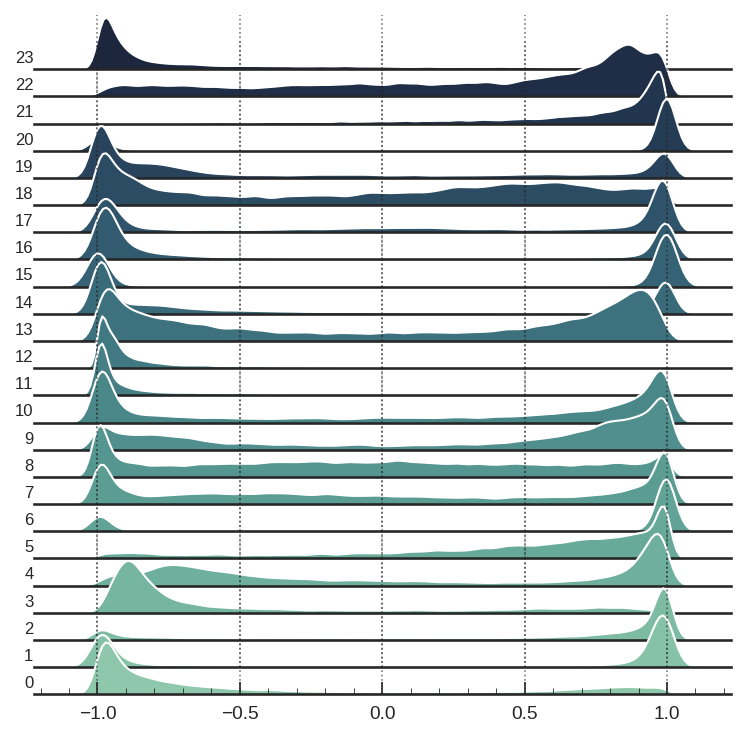

[INFO    ] (min, max): -14.9941, 13.7380


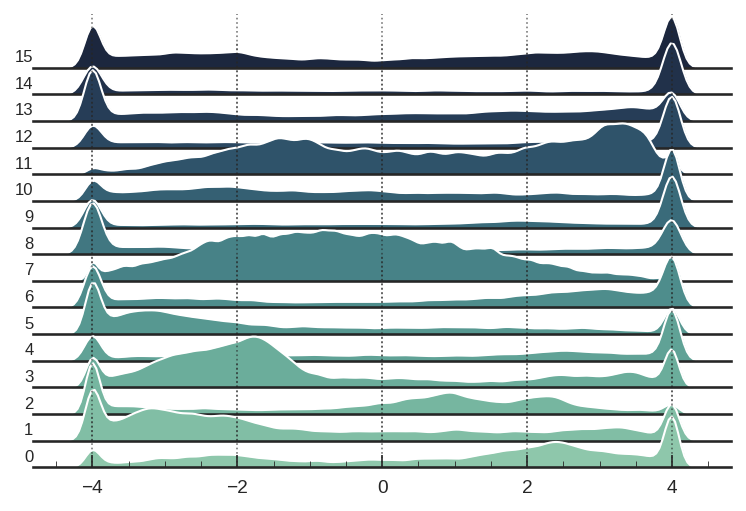

[INFO    ] (min, max): -1.0000, 1.0000


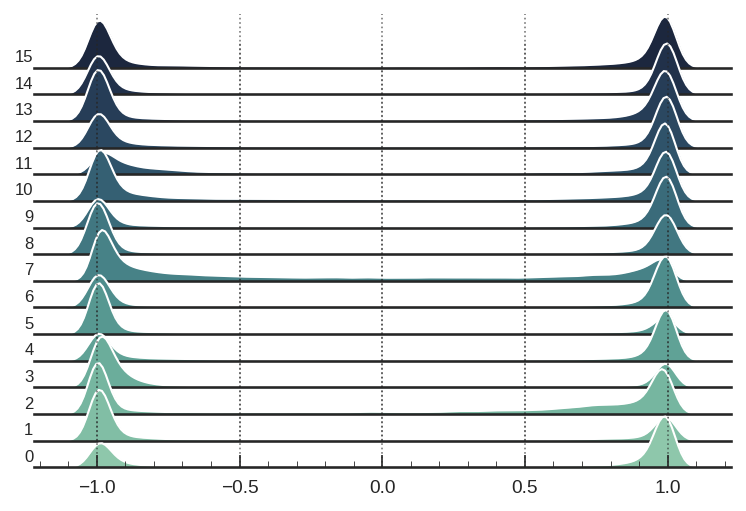

[INFO    ] (min, max): -0.4752, 0.4757


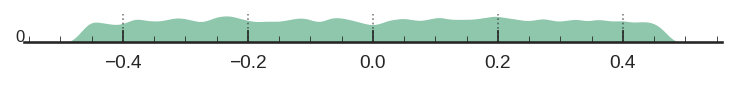

In [28]:
if not do_quantization:
  xx = extracted_preprocessing
  ridgeplot()
  xx = extracted_batch_normalization
  ridgeplot()
  xx = extracted_activation
  ridgeplot()
  xx = extracted_batch_normalization_1
  ridgeplot()
  xx = extracted_activation_1
  ridgeplot()
  xx = extracted_batch_normalization_2
  ridgeplot()
  xx = extracted_activation_2
  ridgeplot()
  xx = extracted_dense_final
  ridgeplot()

[INFO    ] preprocessing (min, max): 0.0000, 0.9873
[INFO    ] batch_normalization (min, max): 0.1718, 0.5069
[INFO    ] batch_normalization_1 (min, max): 0.4147, 2.2003
[INFO    ] batch_normalization_2 (min, max): 0.8288, 1.9310
[INFO    ] preprocessing (min, max): 0.0000, 0.0000
[INFO    ] batch_normalization (min, max): -4.3541, 2.5293
[INFO    ] batch_normalization_1 (min, max): -5.2012, 3.1491
[INFO    ] batch_normalization_2 (min, max): -2.8671, 1.8882
[INFO    ] dense (min, max): -2.1808, 2.8360
[INFO    ] dense_1 (min, max): -4.4252, 4.5443
[INFO    ] dense_2 (min, max): -3.4973, 2.9676
[INFO    ] dense_final (min, max): -2.1032, 2.8399


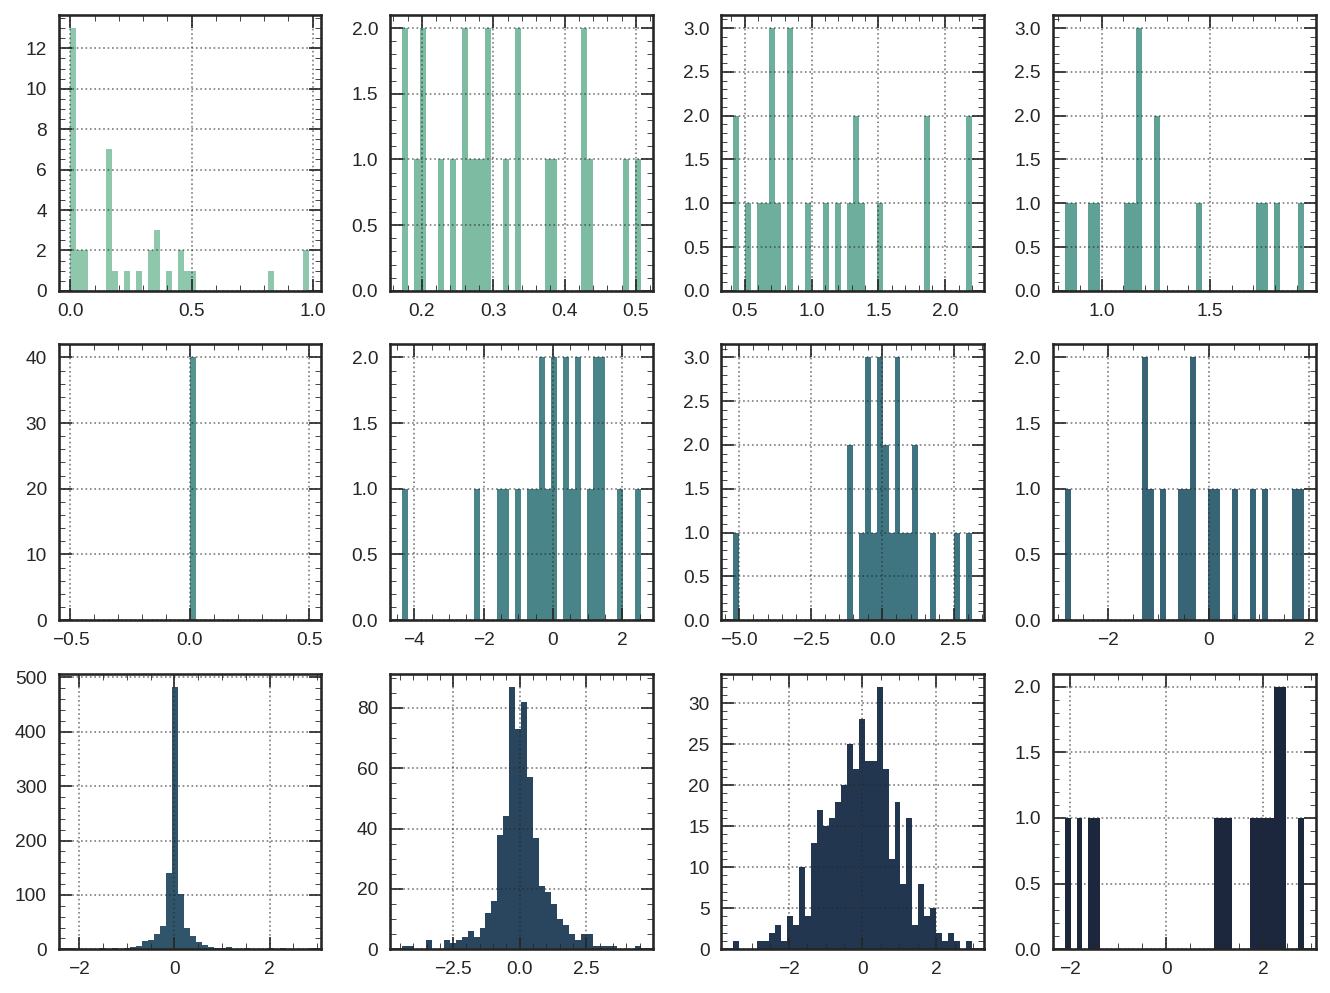

In [29]:
# Inspect model weights
if not do_quantization:
  assert len(model.get_layer('preprocessing').weights) == 2
  assert len(model.get_layer('batch_normalization').weights) == 4
  assert len(model.get_layer('batch_normalization_1').weights) == 4
  assert len(model.get_layer('batch_normalization_2').weights) == 4
  assert len(model.get_layer('dense').weights) == 1
  assert len(model.get_layer('dense_1').weights) == 1
  assert len(model.get_layer('dense_2').weights) == 1
  assert len(model.get_layer('dense_final').weights) == 1

  def get_normalization_scale_and_offset(layer):
    scale = layer.scale.numpy()
    offset = layer.offset.numpy()
    return (scale, offset)

  def get_batchnorm_scale_and_offset(layer):
    scale = (layer.gamma / tf.sqrt(layer.moving_variance)).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  def get_folded_kernel_scale_and_offset(kernel, layer):
    scale = (kernel * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  fig, axs = plt.subplots(3, 4, figsize=(4.5*2,4.5/2*3), tight_layout=True)
  pal = sns.cubehelix_palette(12, rot=-.4, light=.7)

  xx = get_normalization_scale_and_offset(model.get_layer('preprocessing'))[0]
  ax = axs[0,0]
  ax.hist(xx, bins=40, color=pal[0])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization'))[0]
  ax = axs[0,1]
  ax.hist(xx, bins=40, color=pal[1])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_1'))[0]
  ax = axs[0,2]
  ax.hist(xx, bins=40, color=pal[2])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_2'))[0]
  ax = axs[0,3]
  ax.hist(xx, bins=40, color=pal[3])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = get_normalization_scale_and_offset(model.get_layer('preprocessing'))[1]
  ax = axs[1,0]
  ax.hist(xx, bins=40, color=pal[4])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization'))[1]
  ax = axs[1,1]
  ax.hist(xx, bins=40, color=pal[5])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_1'))[1]
  ax = axs[1,2]
  ax.hist(xx, bins=40, color=pal[6])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_2'))[1]
  ax = axs[1,3]
  ax.hist(xx, bins=40, color=pal[7])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = get_folded_kernel_scale_and_offset(model.get_layer('dense').kernel.numpy(), model.get_layer('batch_normalization'))[0]
  ax = axs[2,0]
  ax.hist(xx.reshape(-1), bins=40, color=pal[8])
  logger.info('dense (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_folded_kernel_scale_and_offset(model.get_layer('dense_1').kernel.numpy(), model.get_layer('batch_normalization_1'))[0]
  ax = axs[2,1]
  ax.hist(xx.reshape(-1), bins=40, color=pal[9])
  logger.info('dense_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_folded_kernel_scale_and_offset(model.get_layer('dense_2').kernel.numpy(), model.get_layer('batch_normalization_2'))[0]
  ax = axs[2,2]
  ax.hist(xx.reshape(-1), bins=40, color=pal[10])
  logger.info('dense_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('dense_final').kernel.numpy()
  ax = axs[2,3]
  ax.hist(xx.reshape(-1), bins=40, color=pal[11])
  logger.info('dense_final (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  plt.show()

In [30]:
# Inspect intermediate layers
if do_quantization:
  extractor_layers = [model.get_layer('quant_preprocessing').output,
                      model.get_layer('quant_dense').output,
                      model.get_layer('quant_activation').output,
                      model.get_layer('quant_dense_1').output,
                      model.get_layer('quant_activation_1').output,
                      model.get_layer('quant_dense_2').output,
                      model.get_layer('quant_activation_2').output,
                      model.get_layer('quant_dense_final').output,]

  extractor = tf.keras.Model(inputs=model.inputs, outputs=extractor_layers)

  extracted = extractor(x_test_1)
  extracted = iter(extracted)
  extracted_preprocessing = next(extracted).numpy()
  extracted_dense = next(extracted).numpy()
  extracted_activation = next(extracted).numpy()
  extracted_dense_1 = next(extracted).numpy()
  extracted_activation_1 = next(extracted).numpy()
  extracted_dense_2 = next(extracted).numpy()
  extracted_activation_2 = next(extracted).numpy()
  extracted_dense_final = next(extracted).numpy()

In [31]:
if do_quantization:
  xx = extracted_preprocessing
  ridgeplot()
  xx = extracted_dense
  ridgeplot()
  xx = extracted_activation
  ridgeplot()
  xx = extracted_dense_1
  ridgeplot()
  xx = extracted_activation_1
  ridgeplot()
  xx = extracted_dense_2
  ridgeplot()
  xx = extracted_activation_2
  ridgeplot()
  xx = extracted_dense_final
  ridgeplot()

In [32]:
# Inspect model weights
if do_quantization:
  def get_normalization_scale_and_offset(layer):
    scale = layer.scale.numpy()
    offset = layer.offset.numpy()
    return (scale, offset)

  def get_batchnorm_scale_and_offset(layer):
    scale = (layer.gamma / tf.sqrt(layer.moving_variance)).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  def get_folded_kernel_scale_and_offset(kernel, layer):
    scale = (kernel * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  fig, axs = plt.subplots(3, 4, figsize=(4.5*2,4.5/2*3), tight_layout=True)
  pal = sns.cubehelix_palette(12, rot=-.4, light=.7)

  xx = get_normalization_scale_and_offset(model.get_layer('quant_preprocessing').layer)[0]
  ax = axs[0,0]
  ax.hist(xx, bins=40, color=pal[0])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense').layer.batchnorm)[0]
  ax = axs[0,1]
  ax.hist(xx, bins=40, color=pal[1])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_1').layer.batchnorm)[0]
  ax = axs[0,2]
  ax.hist(xx, bins=40, color=pal[2])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_2').layer.batchnorm)[0]
  ax = axs[0,3]
  ax.hist(xx, bins=40, color=pal[3])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = get_normalization_scale_and_offset(model.get_layer('quant_preprocessing').layer)[1]
  ax = axs[1,0]
  ax.hist(xx, bins=40, color=pal[4])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense').layer.batchnorm)[1]
  ax = axs[1,1]
  ax.hist(xx, bins=40, color=pal[5])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_1').layer.batchnorm)[1]
  ax = axs[1,2]
  ax.hist(xx, bins=40, color=pal[6])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_2').layer.batchnorm)[1]
  ax = axs[1,3]
  ax.hist(xx, bins=40, color=pal[7])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = model.get_layer('quant_dense').layer.folded_kernel.numpy()
  ax = axs[2,0]
  ax.hist(xx.reshape(-1), bins=40, color=pal[8])
  logger.info('dense (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('quant_dense_1').layer.folded_kernel.numpy()
  ax = axs[2,1]
  ax.hist(xx.reshape(-1), bins=40, color=pal[9])
  logger.info('dense_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('quant_dense_2').layer.folded_kernel.numpy()
  ax = axs[2,2]
  ax.hist(xx.reshape(-1), bins=40, color=pal[10])
  logger.info('dense_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('quant_dense_final').layer.folded_kernel.numpy()
  ax = axs[2,3]
  ax.hist(xx.reshape(-1), bins=40, color=pal[11])
  logger.info('dense_final (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  plt.show()